In [1]:
import os
import numpy as np
from scipy.spatial.transform import Rotation as R
from scipy.signal import butter, filtfilt, correlate, find_peaks
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

In [2]:
def get_start_end_times(imu_data, plot_peaks=True):
    # calculate magnitude of acceleration
    imu_mag = np.sqrt(
        imu_data["Accel-X (g)"]**2 +
        imu_data[" Accel-Y (g)"]**2 +
        imu_data[" Accel-Z (g)"]**2
    )

    # find peaks and their properties
    peaks, properties = find_peaks(imu_mag, height=8, distance=100) # 1ms buffer zone

    # sort peaks by height (largest first)
    heights = properties["peak_heights"]
    
    if plot_peaks:
        print(heights)
        
    sorted_by_height = peaks[np.argsort(heights)[::-1]]  # sort descending by height

    # take top 6 peaks (largest heights)
    top6_peaks = np.sort(sorted_by_height[:6])

    # pick rightmost of the left peaks and leftmost of the right peaks among the top 6
    left_peak = top6_peaks[2]
    right_peak = top6_peaks[3]

    print(f"Top 6 peaks (indices): {np.sort(top6_peaks)}")
    print(f"Selected leftmost: {left_peak}, rightmost: {right_peak}")

    imu_data["Time"] = pd.to_datetime(imu_data["Time"], format="%Y-%m-%d %H:%M:%S.%f")

    if plot_peaks:
        for i, p in enumerate([left_peak, right_peak]):
            start_idx = max(0, p - 5000)
            end_idx = min(len(imu_data) - 1, p + 5000)

            plt.figure(figsize=(10, 4))
            plt.plot(imu_data["Time"].iloc[start_idx:end_idx],
                     imu_mag.iloc[start_idx:end_idx],
                     label=f"Peak {i+1} window")

            plt.axvline(imu_data["Time"].iloc[p], color='red', linestyle='--', label="Peak")

            plt.xlabel("Time")
            plt.ylabel("Acceleration Magnitude")
            plt.title(f"IMU Acceleration Around Peak {i+1}")
            plt.legend()
            plt.tight_layout()
            plt.show()

    trimmed_data = imu_data.iloc[left_peak:right_peak].reset_index(drop=True)
    return trimmed_data

def generate_trimmed_resampled_axivity(raw_data_folder, prints = False):
    axivity_data_folder = raw_data_folder + "Axivity Data\\"
    
    imu_data_1 = pd.read_csv(axivity_data_folder + "wrist.resampled.csv", header=0)
    imu_data_2 = pd.read_csv(axivity_data_folder + "lower_back.resampled.csv", header=0)

    if prints:
        print(f"Finding peaks...")
    imu_data_1 = get_start_end_times(imu_data_1, prints)
    imu_data_2 = get_start_end_times(imu_data_2, prints)

    if prints:
        print()
        print("Raw:")
        print(f"Start time 1: {imu_data_1["Time"].iloc[0]}, Start time 2: {imu_data_2["Time"].iloc[0]}")
        print(f"End time 1: {imu_data_1["Time"].iloc[-1]}, End time 2: {imu_data_2["Time"].iloc[-1]}")
        print()
    
    # pick a 'true' time (doesn't really matter so just adjust imu_data_2)
    start_time_diff = imu_data_1["Time"].iloc[0] - imu_data_2["Time"].iloc[0]
    imu_data_2["Time"] = imu_data_2["Time"] + start_time_diff

    if prints:
        print("Adjusted start time:")
        print(f"Start time 1: {imu_data_1["Time"].iloc[0]}, Start time 2: {imu_data_2["Time"].iloc[0]}")
        print(f"End time 1: {imu_data_1["Time"].iloc[-1]}, End time 2: {imu_data_2["Time"].iloc[-1]}")
        print()
    
    # Calculate durations
    duration_1 = imu_data_1['Time'].iloc[-1] - imu_data_1["Time"].iloc[0]
    duration_2 = imu_data_2['Time'].iloc[-1] - imu_data_2['Time'].iloc[0]  # start_time_2 has already been adjusted
    
    # Calculate scaling factor
    scale_factor = duration_1 / duration_2

    if prints:
        print(f"Scale factor: {scale_factor}")
        print()
    
    # Apply scaling to imu_data_2 times
    imu_data_2["Time"] = imu_data_1["Time"].iloc[0] + (imu_data_2["Time"] - imu_data_1["Time"].iloc[0]) * scale_factor

    if prints:
        # Check result
        print("Fully adjusted:")
        print(f"Start time 1: {imu_data_1["Time"].iloc[0]}, Start time 2: {imu_data_2["Time"].iloc[0]}")
        print(f"End time 1: {imu_data_1["Time"].iloc[-1]}, End time 2: {imu_data_2["Time"].iloc[-1]}")
        
        print()
        print("Original:")
        print(f"length of imu_data_1 = {len(imu_data_1["Time"])}")
        print(f"length of imu_data_2 = {len(imu_data_2["Time"])}")
    
    # Step 1: Make sure time is datetime and sorted
    imu_data_1["Time"] = pd.to_datetime(imu_data_1["Time"])
    imu_data_2["Time"] = pd.to_datetime(imu_data_2["Time"])
    imu_data_1 = imu_data_1.sort_values("Time").reset_index(drop=True)
    imu_data_2 = imu_data_2.sort_values("Time").reset_index(drop=True)
    
    # Step 2: Use merge_asof to align imu_data_2 onto imu_data_1's timestamps
    # This allows near-time matching, not exact
    imu_data_2_interp = pd.merge_asof(
        imu_data_1[["Time"]],     # use imu_data_1 timestamps as the reference
        imu_data_2,               # data to be aligned
        on="Time",
        direction="nearest",      # could also try 'forward' or 'backward'
        tolerance=pd.Timedelta("15ms")  # match only if within this range
    )
    
    # Step 1: Set time as index
    imu_data_2_interp = imu_data_2_interp.set_index("Time")
    
    # Step 2: Interpolate over numeric columns using datetime index
    imu_data_2_interp = imu_data_2_interp.interpolate(method="time", limit_area="inside")
    
    # Step 3: Reset index to bring "Time" back as a column
    imu_data_2_interp = imu_data_2_interp.reset_index()
    
    # Step 4: Fill any edge NaNs (if needed)
    imu_data_2_interp = imu_data_2_interp.bfill().ffill()

    if prints:
        print()
        print("Interpolated:")
        print(f"length of imu_data_1 = {len(imu_data_1)}")
        print(f"length of imu_data_2_interp = {len(imu_data_2_interp)}")

    # Our peaks can cause issues with synchronisation - let's crop them off
    # this can be improved if needed
    imu_data_1 = imu_data_1.iloc[200:-200]
    imu_data_2_interp = imu_data_2_interp.iloc[200:-200]
    
    # now save the data as csv in the axivity folder
    imu_data_1.to_csv(axivity_data_folder+"trimmed_resampled_wrist.csv")
    imu_data_2_interp.to_csv(axivity_data_folder+"trimmed_resampled_lower_back.csv")


Finding peaks...
[13.85372908 13.85231991 13.85485641 12.9984505  13.85077076 13.85612472]
Top 6 peaks (indices): [  1192   2013   3400 304447 305442 306421]
Selected leftmost: 3400, rightmost: 304447


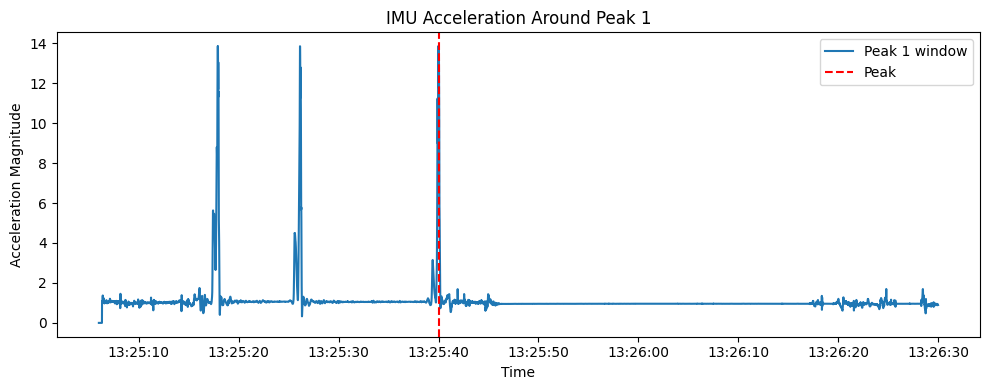

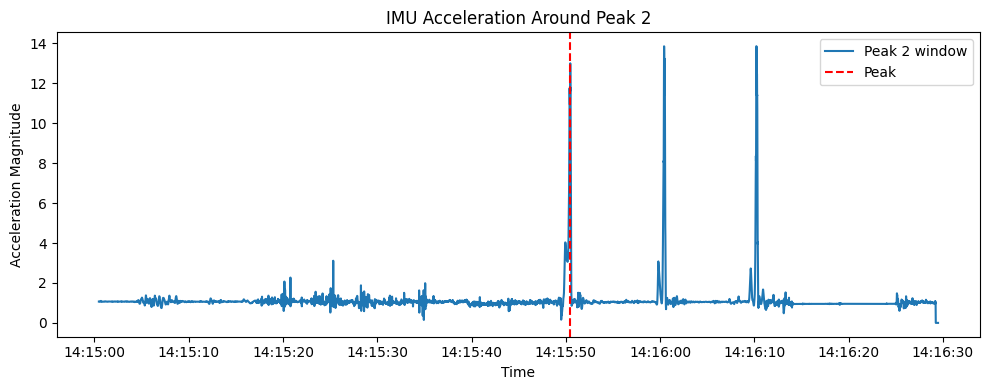

[13.85612472 13.84415403 13.85612472 12.58642145 13.84527973 13.85598384]
Top 6 peaks (indices): [   988   1813   3200 304245 305240 306219]
Selected leftmost: 3200, rightmost: 304245


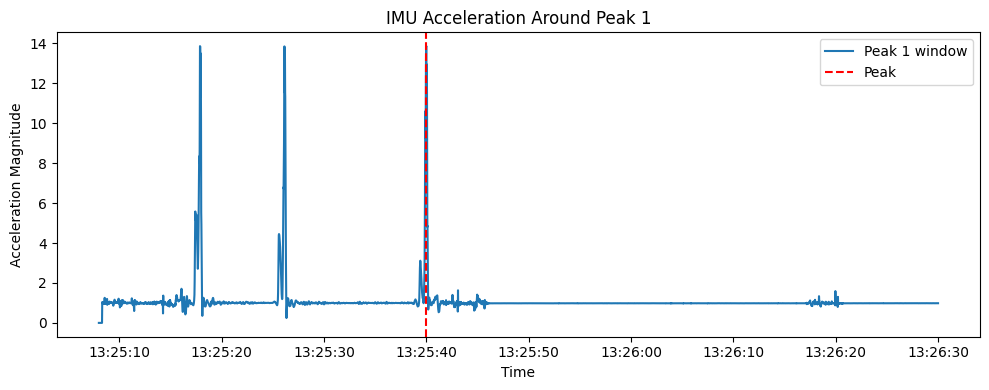

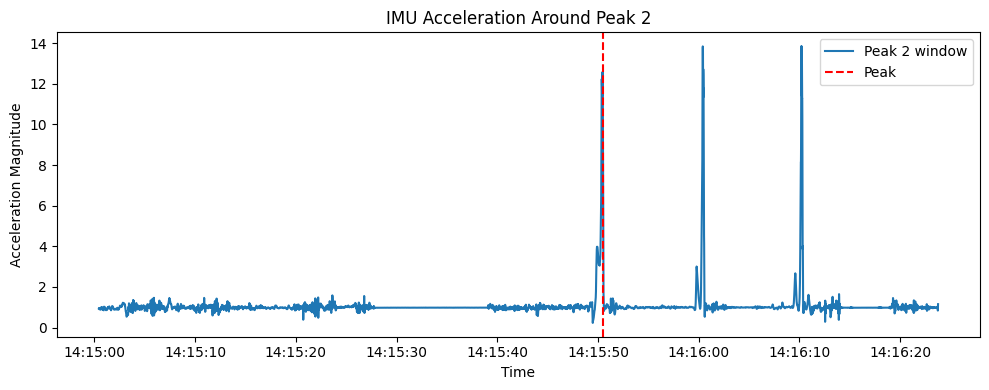


Raw:
Start time 1: 2025-08-19 13:25:40, Start time 2: 2025-08-19 13:25:40
End time 1: 2025-08-19 14:15:50.460000, End time 2: 2025-08-19 14:15:50.440000

Adjusted start time:
Start time 1: 2025-08-19 13:25:40, Start time 2: 2025-08-19 13:25:40
End time 1: 2025-08-19 14:15:50.460000, End time 2: 2025-08-19 14:15:50.440000

Scale factor: 1.0000066435471227

Fully adjusted:
Start time 1: 2025-08-19 13:25:40, Start time 2: 2025-08-19 13:25:40
End time 1: 2025-08-19 14:15:50.460000, End time 2: 2025-08-19 14:15:50.460000

Original:
length of imu_data_1 = 301047
length of imu_data_2 = 301045

Interpolated:
length of imu_data_1 = 301047
length of imu_data_2_interp = 301047


In [5]:
raw_data_folder = r"C:\Users\ac4jmi\Desktop\DMO4LNC\Data Collection\Dataset\CP\875\Lab\\"
generate_trimmed_resampled_axivity(raw_data_folder, prints=True)